<a href="https://colab.research.google.com/github/Aditya-Singhvi/blotto-sim/blob/main/blotto_simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import random
import pandas as pd
import copy

In [ ]:
class GameResult:
  def __init__(self, round, id0, id1, points, castles_won, is_bonus):
    self.round = round
    self.id0 = id0
    self.id1 = id1
    self.points = points
    self.castles_won = castles_won
    self.is_bonus = is_bonus

  def lookup(self, id):
    if id == self.id0:
      return self.points[0], self.castles_won[0], self.is_bonus[0]
    elif id == self.id1:
      return self.points[1], self.castles_won[1], self.is_bonus[1]
    else:
      assert False

  def get_opponent(self, id):
    if id == self.id0:
      return self.id1
    elif id == self.id1:
      return self.id0
    else:
      assert False

In [ ]:
class BlottoBoard:
  def __init__(self, board, id):
    self.board = board
    self.id = id
    self.num_soldiers = sum(self.board)
    self.results = []
    self.points = 0
    self.ewma_points = 0
    self.alpha = 0.02
    self.rank = None

  def append_result(self, result):
    self.results.append(result)
    points = result.lookup(self.id)[0]
    self.points += points
    self.ewma_points = (self.alpha * points) + (1 - self.alpha) * self.ewma_points

  def set_rank(self, rank):
    self.rank = rank

  def to_dict(self):
    return {
      'id': self.id,
      'board': self.board,
      'num_games': len(self.results),
      'avg_points': self.points / len(self.results),
      'ewma_points': self.ewma_points,
      'avg_castles_won': np.mean([len(result.lookup(self.id)[1]) for result in self.results]),
      'prop_bonus_earned' : np.mean([result.lookup(self.id)[2] for result in self.results]),
      'points': [result.lookup(self.id)[0] for result in self.results],
      'castles_won': [result.lookup(self.id)[1] for result in self.results],
      'opponents': [result.get_opponent(self.id) for result in self.results],
    }

In [ ]:
class BlottoGenerator:
  def __init__(self, num_soldiers, num_castles):
    self.num_soldiers = num_soldiers
    self.num_castles = num_castles
    self.balls_and_bins = np.concatenate((np.zeros(num_soldiers), np.ones(num_castles - 1)))
    self.id_counter = -1

  def gen(self):
    random.shuffle(self.balls_and_bins)
    dividers = np.nonzero(self.balls_and_bins)[0]
    self.id_counter += 1
    return BlottoBoard(np.diff(dividers, prepend=[-1], append=[len(self.balls_and_bins)]) - 1, self.id_counter)

  def gen_custom_boards(self, custom_boards):
    out = []
    for custom_board in custom_boards:
      self.id_counter += 1
      out.append(BlottoBoard(custom_board, self.id_counter))

    return out

In [ ]:
class RoundSimulator:
  def __init__(self, num_boards, num_soldiers, num_castles, custom_boards=[]):
    self.generator = BlottoGenerator(num_soldiers, num_castles)
    self.boards = [self.generator.gen() for _ in range(num_boards - len(custom_boards))] + self.generator.gen_custom_boards(custom_boards)
    self.valid_boards = copy.copy(self.boards)
    self.num_rounds = 0
    self.cullings = []

  def _sort_valid_boards(self):
    self.valid_boards.sort(key=(lambda x: x.ewma_points), reverse=True)
    for i in range(len(self.valid_boards)):
      self.valid_boards[i].set_rank(i)

  def _simulate(self, board1, board2):
    points = [0, 0]
    castles_won = [[], []]
    for i in range(len(board1)):
      if board1[i] != board2[i]:
        winning_idx = 0 if board1[i] > board2[i] else 1
        points[winning_idx] += (i + 1)
        castles_won[winning_idx].append(i + 1)

    is_bonus = [False, False]
    for idx in range(2):
      if len(castles_won[idx]) != 0:
        points[idx] -= castles_won[idx][-1]

    return points, castles_won, is_bonus

  def simulate_round(self):
    random.shuffle(self.valid_boards)
    for i in range(0, len(self.valid_boards), 2):
      board1 = self.valid_boards[i]
      board2 = self.valid_boards[i + 1]
      points, castles_won, is_bonus = self._simulate(board1.board, board2.board)
      result = GameResult(self.num_rounds, board1.id, board2.id, points, castles_won, is_bonus)
      board1.append_result(result)
      board2.append_result(result)

    self.num_rounds += 1

  def cull_the_herd(self, proportion_to_keep):
    assert(0 < proportion_to_keep < 1)
    self._sort_valid_boards()
    num_to_keep = (int(len(self.valid_boards) * proportion_to_keep) // 2) * 2
    self.valid_boards = self.valid_boards[:num_to_keep]
    self.cullings.append((self.num_rounds, num_to_keep))

  def to_results_df(self):
    self._sort_valid_boards()
    df = pd.DataFrame([board.to_dict() for board in self.valid_boards])
    df['avg_opponent_rank'] = df.apply(lambda row: np.mean([self.boards[id].rank for id in row['opponents']]), axis=1)
    return df


In [ ]:
NUM_BOARDS = 2 ** 15
CULL_FREQUENCY = 32 # every CULL_FREQUENCY rounds
CULL_PROPORTION = 0.5
DESIRED_NUM = 16

custom_boards = [[1, 2, 6, 8, 8, 10, 12, 15, 30, 8]]

simulator = RoundSimulator(NUM_BOARDS, 100, 10, custom_boards=custom_boards)
while len(simulator.valid_boards) > DESIRED_NUM:
  for _ in range(CULL_FREQUENCY):
    simulator.simulate_round()
  simulator.cull_the_herd(CULL_PROPORTION)

df = simulator.to_results_df()
average_top_board = np.mean(df['board'], axis=0)

In [ ]:
df

,id,board,num_games,avg_points,ewma_points,avg_castles_won,prop_bonus_earned,points,castles_won,opponents,avg_opponent_rank
0,18260,"[4, 3, 6, 4, 15, 17, 0, 4, 28, 19]",352,18.883523,19.092813,5.028409,0.0,"[17, 26, 22, 22, 22, 18, 21, 25, 19, 25, 32, 2...","[[3, 5, 9, 10], [1, 3, 5, 8, 9, 10], [2, 5, 6,...","[2613, 15324, 29979, 16655, 13394, 17740, 1107...",3392.982955
1,14078,"[3, 1, 8, 9, 14, 21, 22, 6, 16, 0]",352,19.204545,19.061878,5.215909,0.0,"[21, 26, 17, 18, 18, 15, 23, 23, 22, 22, 12, 3...","[[6, 7, 8, 9], [3, 4, 5, 6, 8, 9], [4, 6, 7, 9...","[7273, 6429, 32000, 4403, 6800, 20590, 23345, ...",3007.119318
2,24866,"[2, 2, 13, 11, 14, 21, 19, 3, 3, 12]",352,18.877841,19.056170,5.329545,0.0,"[25, 13, 29, 21, 25, 30, 22, 17, 22, 20, 31, 1...","[[3, 4, 5, 6, 7, 10], [3, 4, 6, 7], [3, 5, 6, ...","[1757, 31745, 10819, 12385, 3154, 13728, 3360,...",3061.792614
3,14067,"[1, 2, 11, 5, 17, 18, 0, 5, 27, 14]",352,18.926136,19.045918,4.889205,0.0,"[23, 21, 18, 26, 18, 15, 30, 26, 20, 8, 18, 8,...","[[3, 5, 6, 9, 10], [3, 4, 6, 8, 10], [3, 4, 5,...","[17626, 10142, 2373, 31937, 3517, 9225, 19397,...",3197.184659
4,13570,"[0, 6, 5, 6, 5, 18, 7, 7, 30, 16]",352,19.718750,18.903696,4.713068,0.0,"[14, 17, 33, 23, 25, 34, 24, 26, 22, 33, 18, 2...","[[2, 4, 8, 9], [8, 9, 10], [3, 6, 7, 8, 9, 10]...","[18747, 5324, 17600, 12864, 965, 7543, 1860, 2...",3220.082386
5,20037,"[3, 2, 0, 0, 15, 17, 1, 27, 15, 20]",352,19.335227,18.625380,4.482955,0.0,"[30, 24, 22, 29, 30, 28, 13, 28, 23, 22, 28, 2...","[[2, 5, 6, 8, 9, 10], [1, 6, 8, 9, 10], [5, 8,...","[21655, 23371, 1683, 4976, 4235, 3245, 31561, ...",2979.059659
6,20730,"[0, 2, 3, 12, 10, 4, 8, 29, 25, 7]",352,19.284091,18.456630,4.420455,0.0,"[19, 15, 13, 26, 30, 17, 26, 30, 24, 20, 26, 2...","[[4, 7, 8, 9], [7, 8, 9], [3, 4, 6, 9], [4, 5,...","[24942, 19168, 3352, 25742, 21188, 30026, 8994...",3243.139205
7,13543,"[4, 3, 1, 6, 16, 18, 9, 27, 6, 10]",352,18.934659,18.456181,5.000000,0.0,"[22, 15, 18, 15, 36, 19, 22, 25, 19, 22, 18, 1...","[[4, 5, 6, 7, 8], [4, 5, 6, 8], [5, 6, 7, 10],...","[24228, 7456, 18462, 16266, 18919, 15988, 8021...",2945.488636
8,25060,"[1, 5, 9, 14, 14, 1, 6, 1, 21, 28]",352,18.707386,18.228208,5.059659,0.0,"[23, 24, 18, 21, 18, 20, 21, 18, 23, 24, 14, 2...","[[2, 3, 4, 5, 9, 10], [3, 5, 7, 9, 10], [2, 3,...","[3646, 19323, 2090, 27247, 2150, 22670, 483, 1...",2746.991477
9,28418,"[0, 1, 9, 8, 1, 22, 24, 0, 8, 27]",352,18.673295,18.050379,4.482955,0.0,"[20, 26, 21, 25, 16, 13, 23, 17, 25, 27, 19, 2...","[[3, 4, 6, 7, 9], [4, 6, 7, 9, 10], [3, 5, 6, ...","[12395, 32384, 7908, 26369, 27818, 28159, 4187...",2832.107955


In [ ]:
np.round(average_top_board)

array([ 2.,  3.,  6.,  8., 11., 15., 13., 11., 16., 15.])

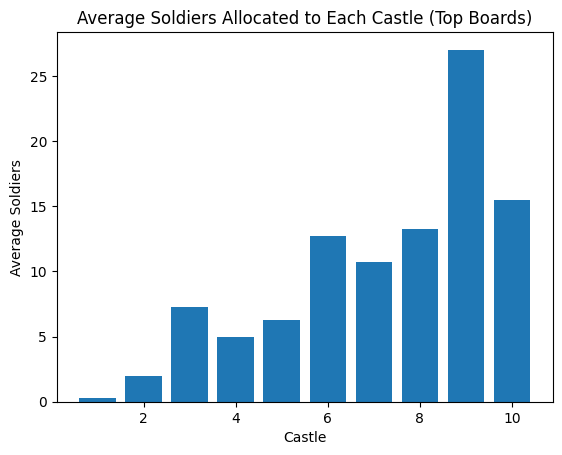

In [ ]:
# prompt: create a bar chart of average_top_board

import matplotlib.pyplot as plt

plt.bar(range(1, len(average_top_board) + 1), average_top_board)
plt.xlabel('Castle')
plt.ylabel('Average Soldiers')
plt.title('Average Soldiers Allocated to Each Castle (Top Boards)')
plt.show()